# Supervised Contrastive Learning on Fashion MNIST (NT-Xent)

In [1]:
# install dependencies
!pip uninstall -y numpy tensorflow tensorflow-addons
!pip install -q tensorflow==2.15.0 tensorflow-addons==0.23.0

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Successfully uninstalled tensorflow-addons-0.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tensorstore 0.1.74 requires ml_dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
jax 0.5.2 requires ml_dtypes>=0.4.0, but you have ml-dtypes 0.2.0 which is incompatible.


In [2]:
# imports
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


tf.random.set_seed(42)
np.random.seed(42)

BATCH_SIZE = 512
EPOCHS = 15
PROJ_DIM = 128
TEMPERATURE = 0.1
NORMALIZE = True

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.
x_test = x_test.reshape(-1, 28*28).astype("float32") / 255.

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Encoder and Projection Head

These networks map raw 784D vectors to a compact 128D representation space. The projection head is L2-normalized and used for contrastive loss computation.

In [4]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128)
        ])

    def call(self, x):
        h = self.seq(x)
        return tf.math.l2_normalize(h, axis=-1) if NORMALIZE else h

class Projector(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.linear = tf.keras.layers.Dense(PROJ_DIM)

    def call(self, x):
        z = self.linear(x)
        return tf.math.l2_normalize(z, axis=-1)

# NT-Xent Loss & Training Step

In [5]:
def supervised_nt_xent_loss(features, labels, temperature=0.1):
    features = tf.math.l2_normalize(features, axis=1)
    sim_matrix = tf.matmul(features, features, transpose_b=True)
    labels = tf.expand_dims(labels, 1)
    mask = tf.cast(tf.equal(labels, tf.transpose(labels)), dtype=tf.float32)
    logits = sim_matrix / temperature
    logits_mask = tf.ones_like(mask) - tf.eye(tf.shape(mask)[0])
    mask = mask * logits_mask
    log_prob = tf.nn.log_softmax(logits, axis=1)
    mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / tf.reduce_sum(mask, axis=1)

    return -tf.reduce_mean(mean_log_prob_pos)

# Train Loop + Loss Plot

In [6]:
encoder = Encoder()
projector = Projector()
optimizer = tf.keras.optimizers.Adam(1e-3)

@tf.function
def train_step_npair(x, y):
    with tf.GradientTape() as tape:
        z = projector(encoder(x, training=True), training=True)
        loss = supervised_nt_xent_loss(z, y)
    grads = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + projector.trainable_variables))
    return loss

# train encoder
for epoch in range(EPOCHS):
    losses = []
    for x_batch, y_batch in train_ds:
        loss = train_step_npair(x_batch, y_batch)
        losses.append(loss.numpy())
    print(f"[N-Pair] Epoch {epoch+1}: Loss = {np.mean(losses):.4f}")

[N-Pair] Epoch 1: Loss = 4.7560
[N-Pair] Epoch 2: Loss = 4.5518
[N-Pair] Epoch 3: Loss = 4.4934
[N-Pair] Epoch 4: Loss = 4.4571
[N-Pair] Epoch 5: Loss = 4.4181
[N-Pair] Epoch 6: Loss = 4.3959
[N-Pair] Epoch 7: Loss = 4.3824
[N-Pair] Epoch 8: Loss = 4.3570
[N-Pair] Epoch 9: Loss = 4.3445
[N-Pair] Epoch 10: Loss = 4.3333
[N-Pair] Epoch 11: Loss = 4.3231
[N-Pair] Epoch 12: Loss = 4.3082
[N-Pair] Epoch 13: Loss = 4.2997
[N-Pair] Epoch 14: Loss = 4.2876
[N-Pair] Epoch 15: Loss = 4.2809


In [7]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        z = projector(encoder(x, training=True), training=True)
        loss = supervised_nt_xent_loss(z, y, temperature=TEMPERATURE)
    grads = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + projector.trainable_variables))
    return loss


loss_history = []
for epoch in range(EPOCHS):
    batch_losses = []
    for x_batch, y_batch in train_ds:
        loss = train_step(x_batch, y_batch)
        batch_losses.append(loss.numpy())
    avg_loss = np.mean(batch_losses)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}: Contrastive Loss = {avg_loss:.4f}")

Epoch 1: Contrastive Loss = 4.2733
Epoch 2: Contrastive Loss = 4.2631
Epoch 3: Contrastive Loss = 4.2624
Epoch 4: Contrastive Loss = 4.2466
Epoch 5: Contrastive Loss = 4.2347
Epoch 6: Contrastive Loss = 4.2339
Epoch 7: Contrastive Loss = 4.2292
Epoch 8: Contrastive Loss = 4.2222
Epoch 9: Contrastive Loss = 4.2141
Epoch 10: Contrastive Loss = 4.2171
Epoch 11: Contrastive Loss = 4.1958
Epoch 12: Contrastive Loss = 4.1931
Epoch 13: Contrastive Loss = 4.1961
Epoch 14: Contrastive Loss = 4.1881
Epoch 15: Contrastive Loss = 4.1785


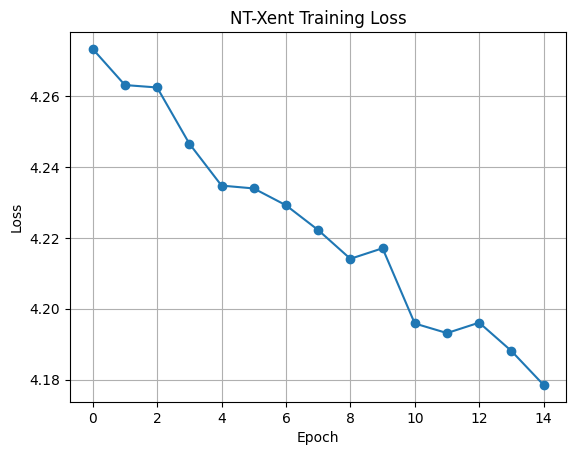

In [8]:
# loss curve
plt.plot(loss_history, marker='o')
plt.title("NT-Xent Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Visualizing Learned Representations

- **PCA** to reduce dimensionality linearly
- **t-SNE** for nonlinear manifold projection
- **Centroid plot** to show class separation
- **Similarity heatmap** to show intra-class closeness


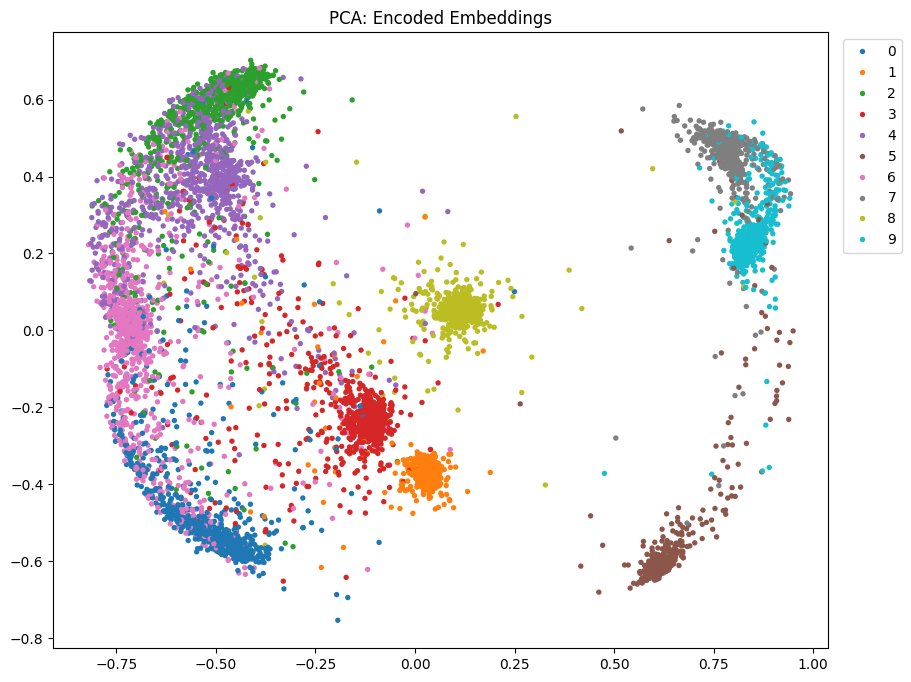

In [9]:
features = encoder(x_test).numpy()

# pca
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(features)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_proj[:, 0], y=pca_proj[:, 1], hue=y_test, palette="tab10", s=15, linewidth=0)
plt.title("PCA: Encoded Embeddings")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x78b7a19a4540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __i

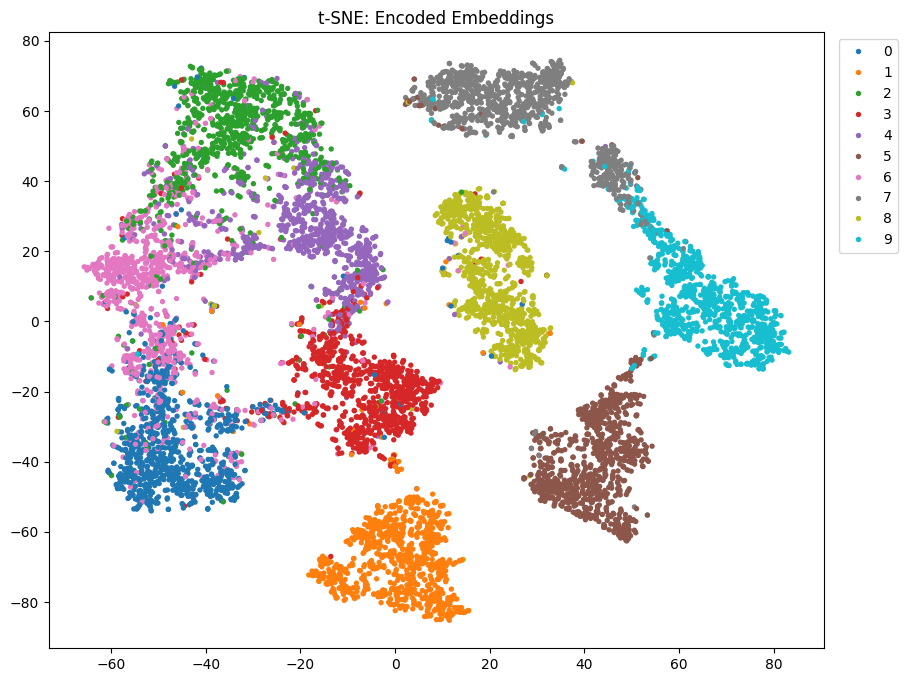

In [10]:
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_proj = tsne.fit_transform(features)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=y_test, palette="tab10", s=15, linewidth=0)
plt.title("t-SNE: Encoded Embeddings")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.show()

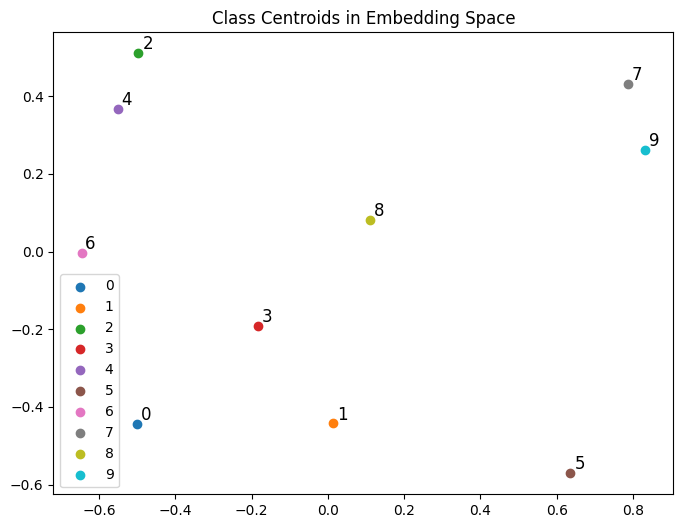

In [11]:
# class centroids
centroids = np.vstack([features[y_test == i].mean(axis=0) for i in range(10)])
pca_centroids = PCA(n_components=2).fit_transform(centroids)
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(pca_centroids):
    plt.scatter(x, y, label=str(i))
    plt.text(x + 0.01, y + 0.01, str(i), fontsize=12)
plt.title("Class Centroids in Embedding Space")
plt.legend()
plt.show()

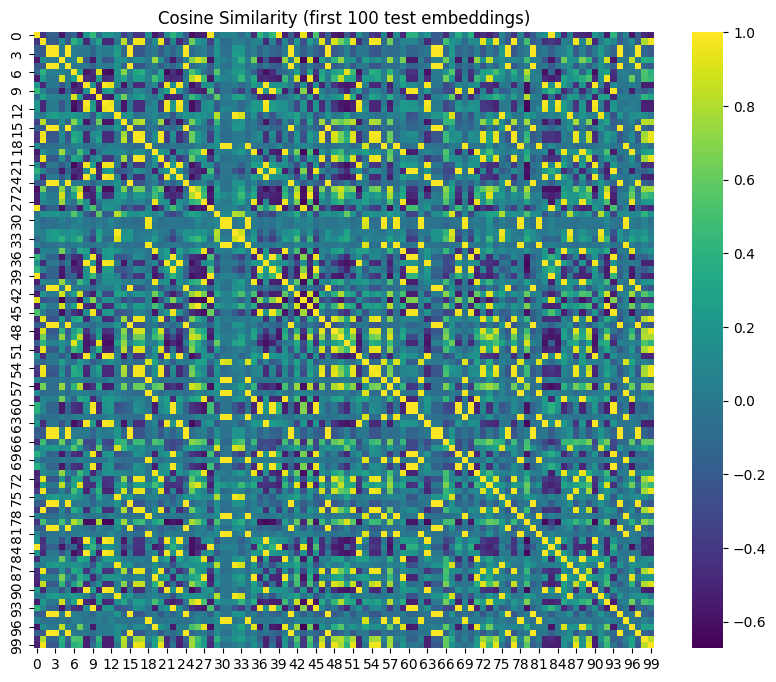

In [12]:
# cosine similarity heatmap
sim_matrix = np.matmul(features[:100], features[:100].T)
plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, cmap='viridis')
plt.title("Cosine Similarity (first 100 test embeddings)")
plt.show()

# Softmax Classifier

In [13]:
# train linear classifier
classifier = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,)),
    tf.keras.layers.Dense(10)
])

classifier.compile(optimizer="adam",
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=["accuracy"])

classifier.fit(encoder(x_train), y_train,
               validation_data=(encoder(x_test), y_test),
               epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4923 - accuracy: 0.9306 - val_loss: 0.3509 - val_accuracy: 0.8902
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1479 - accuracy: 0.9549 - val_loss: 0.3551 - val_accuracy: 0.8904
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1344 - accuracy: 0.9562 - val_loss: 0.3619 - val_accuracy: 0.8910
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1304 - accuracy: 0.9569 - val_loss: 0.3652 - val_accuracy: 0.8916
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1285 - accuracy: 0.9573 - val_loss: 0.3670 - val_accuracy: 0.8921
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1271 - accuracy: 0.9575 - val_loss: 0.3686 - val_accuracy: 0.8922
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1261 - accuracy: 0.9579 - val_loss: 0.3685 - val_accuracy:

# Supervised NT-Xent Loss

In [14]:
# reset models
encoder = Encoder()
projector = Projector()
optimizer = tf.keras.optimizers.Adam(1e-3)

def supervised_nt_xent_loss(features, labels, temperature=0.1):
    """Compute supervised NT-Xent loss."""
    features = tf.math.l2_normalize(features, axis=1)
    similarity_matrix = tf.matmul(features, features, transpose_b=True)

    labels = tf.expand_dims(labels, 1)
    mask = tf.cast(tf.equal(labels, tf.transpose(labels)), dtype=tf.float32)
    logits = similarity_matrix / temperature

    # mask out self-similarities
    logits_mask = tf.ones_like(mask) - tf.eye(tf.shape(mask)[0])
    mask = mask * logits_mask

    log_prob = tf.nn.log_softmax(logits, axis=1)
    mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / tf.reduce_sum(mask, axis=1)

    loss = -tf.reduce_mean(mean_log_prob_pos)
    return loss

In [15]:
@tf.function
def train_step_ntxent(x, y):
    with tf.GradientTape() as tape:
        z = projector(encoder(x, training=True), training=True)
        loss = supervised_nt_xent_loss(z, y, temperature=TEMPERATURE)
    grads = tape.gradient(loss, encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + projector.trainable_variables))
    return loss

# train
for epoch in range(EPOCHS):
    losses = []
    for x_batch, y_batch in train_ds:
        loss = train_step_ntxent(x_batch, y_batch)
        losses.append(loss.numpy())
    print(f"[NT-Xent] Epoch {epoch+1}: Loss = {np.mean(losses):.4f}")

[NT-Xent] Epoch 1: Loss = 4.7417
[NT-Xent] Epoch 2: Loss = 4.5483
[NT-Xent] Epoch 3: Loss = 4.4886
[NT-Xent] Epoch 4: Loss = 4.4444
[NT-Xent] Epoch 5: Loss = 4.4198
[NT-Xent] Epoch 6: Loss = 4.4033
[NT-Xent] Epoch 7: Loss = 4.3779
[NT-Xent] Epoch 8: Loss = 4.3636
[NT-Xent] Epoch 9: Loss = 4.3477
[NT-Xent] Epoch 10: Loss = 4.3365
[NT-Xent] Epoch 11: Loss = 4.3202
[NT-Xent] Epoch 12: Loss = 4.3123
[NT-Xent] Epoch 13: Loss = 4.3049
[NT-Xent] Epoch 14: Loss = 4.2954
[NT-Xent] Epoch 15: Loss = 4.2806


# PCA of NT-Xent Embedding

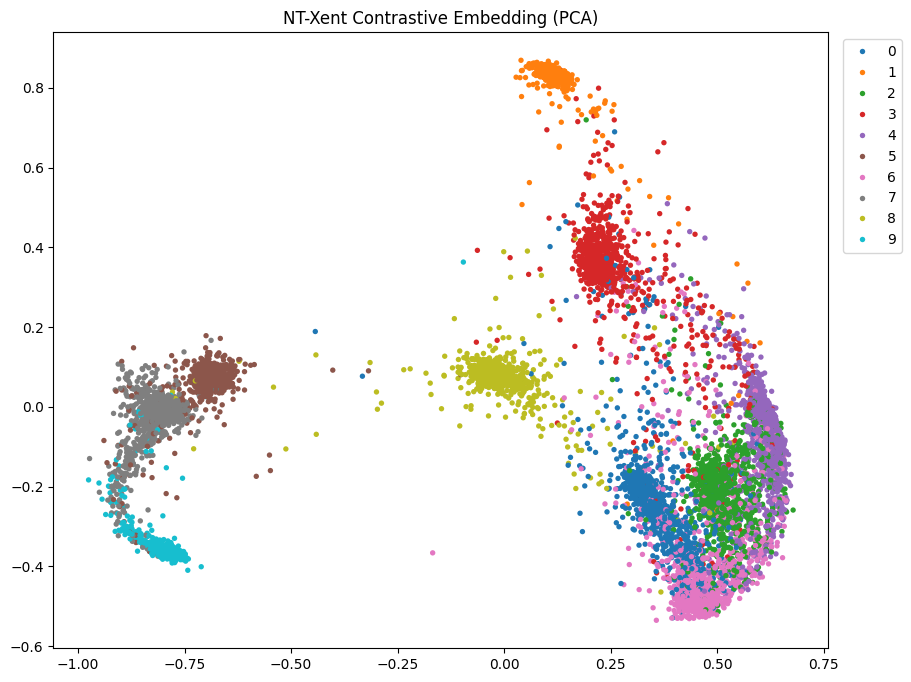

In [16]:
features = encoder(x_test).numpy()
proj = PCA(n_components=2).fit_transform(features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=y_test, palette='tab10', s=15, linewidth=0)
plt.title("NT-Xent Contrastive Embedding (PCA)")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

# Classifier on NT-Xent Features

In [17]:
clf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,)),
    tf.keras.layers.Dense(10)
])

clf.compile(optimizer="adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

clf.fit(encoder(x_train), y_train,
        validation_data=(encoder(x_test), y_test),
        epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5416 - accuracy: 0.9176 - val_loss: 0.3374 - val_accuracy: 0.8904
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1938 - accuracy: 0.9369 - val_loss: 0.3298 - val_accuracy: 0.8909
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1814 - accuracy: 0.9379 - val_loss: 0.3322 - val_accuracy: 0.8919
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1777 - accuracy: 0.9383 - val_loss: 0.3324 - val_accuracy: 0.8932
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1758 - accuracy: 0.9390 - val_loss: 0.3333 - val_accuracy: 0.8925
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1745 - accuracy: 0.9393 - val_loss: 0.3332 - val_accuracy: 0.8929
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1734 - accuracy: 0.9393 - val_loss: 0.3330 - val_accuracy: